In [1]:
import xgboost as xbg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib

%matplotlib inline

In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

In [4]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [5]:
print(len(X_train))

75000


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier


In [14]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [15]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [16]:
#model = XGBClassifier(n_jobs=-1,verbosity=2,n_estimators=300)
#model.fit(X_train_f,y_train,verbose=True,eval_set=[(X_val_f,y_val)])

model1 = ExtraTreeClassifier(random_state=0)
# model.fit(X_train_f,y_train)

In [17]:
from sklearn.model_selection import GridSearchCV
parameters = {'min_samples_split': range(5, 30, 5), 
              'max_depth': range(1, 40, 2),
          #    'criterion':['gini','entropy'],
         #      'splitter':['best','random'],
              # 'max_features':['auto','log2','None'],
               #'presort':['False','True']
             }

In [18]:
model1.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [19]:
gs_clf = GridSearchCV(model1,parameters, cv=3, n_jobs=-1, verbose=1)

In [20]:
model = gs_clf.fit(X_train_f, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


In [21]:
model.best_score_

0.54856

In [22]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'max_depth': 39, 'min_samples_split': 10}
max_depth: 39
min_samples_split: 10


In [23]:
pickle.dump(model,open("ET_Tokens_"+str(trainSamples)+"_.pkl",'wb'))

In [24]:
# from sklearn.metrics import accuracy_score
# preds_val = model.predict(X_val_f)
# accuracy = accuracy_score(y_val, preds_val)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [25]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [26]:
X_test_f =feature_pipeline.transform(X_test)

In [27]:
# preds_test = model.predict(X_test_f)
# accuracy = accuracy_score(y_test, preds_test)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [34]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open("/scratch/pbanerj6/sml-dataset/ranking_"+fname+".p","rb"))

In [35]:
valAccuracy = []
testAccuracy = []
mrrScore = []
from sklearn.metrics import accuracy_score
import time
# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = ExtraTreeClassifier(min_samples_split=model.best_params_['min_samples_split'],
                                       max_depth=model.best_params_['max_depth'],
                                       #criterion=model.best_params_['criterion'],
                                       #splitter=model.best_params_['splitter']
                                   )

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    mrr = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)

SampleSize: 100
Train Time:0.46 sec
Validation Accuracy: 50.44%
Validation Time:2.65 sec
Test Accuracy: 50.01%
Test Time:2.94 sec
MRR: (0.31500663780663496, 0.03933333333333333, 0.07933333333333334)
MRR Time:0.27 sec
SampleSize: 500
Train Time:0.28 sec
Validation Accuracy: 50.40%
Validation Time:2.66 sec
Test Accuracy: 50.63%
Test Time:2.45 sec
MRR: (0.31911491101490735, 0.05, 0.07333333333333333)
MRR Time:0.46 sec
SampleSize: 1000
Train Time:0.34 sec
Validation Accuracy: 50.68%
Validation Time:2.57 sec
Test Accuracy: 50.68%
Test Time:2.64 sec
MRR: (0.3447943722943697, 0.056, 0.43733333333333335)
MRR Time:0.46 sec
SampleSize: 10000
Train Time:4.44 sec
Validation Accuracy: 53.93%
Validation Time:2.61 sec
Test Accuracy: 53.21%
Test Time:2.60 sec
MRR: (0.3668585377585358, 0.064, 0.51)
MRR Time:0.26 sec
SampleSize: 20000
Train Time:8.26 sec
Validation Accuracy: 53.65%
Validation Time:2.39 sec
Test Accuracy: 54.41%
Test Time:2.55 sec
MRR: (0.4225957190957182, 0.14266666666666666, 0.51)
MRR 

In [44]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("ET_Tokens_Accuracy.png")
    #plt.show()

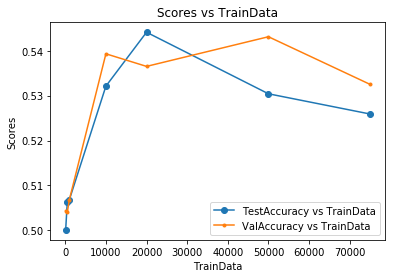

In [45]:
accuracyVisualization()

In [46]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("ET_Tokens_Mrr.png")
    plt.show()

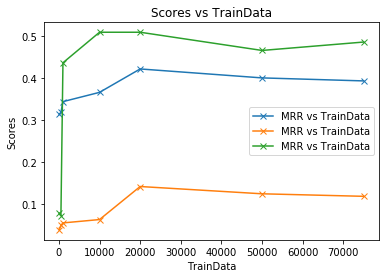

In [47]:
mrrVisualization()

In [48]:
preds_test_probs = model.predict_proba(X_test_f)

In [49]:
qid2c,qid2indexmap = load_ranking("test")

In [50]:
mrrwrapper(qid2c,qid2indexmap,preds_test_probs)

(0.3671667628667609, 0.08533333333333333, 0.45066666666666666)

In [51]:
preds_test_probs

array([[0.49903867, 0.50096133],
       [0.49903867, 0.50096133],
       [1.        , 0.        ],
       ...,
       [0.49903867, 0.50096133],
       [0.49903867, 0.50096133],
       [0.49903867, 0.50096133]])